<a href="https://colab.research.google.com/github/mangare91/Drug_Discover_Portifolio_projects/blob/main/Tomato_leaf_Disease_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detection of Tomato Leaf Diseases using CNN

#### This Research Project is an approach to the development of tomato plant disease recognition model, based on leaf image classification, by the use of deep convolutional networks. The developed model is able to recognize 10 different classes of tomato leaf diseases 

The dataset contains:
* Number of training images:  18345
* Number of testing images:  4585

Workflow:
1. Loading the images from the folder resizing them into 128 * 128 (256 * 256 takes time for processing) and coverting them to tensors 
2. Building a validation dataset using 0.3% of the total dataset.
3. Loading the data using Batches
4. Trying various CNN architecture
  * Combination of Multilayer CNN with Linear Layers
  * VGG16 using Transfer Learning
  * Resnet34 using Transfer Learning
5. Selecting the device and loading the data into device i.e (GPU) 
6. Training the model and evaluating the model on test data
7. Saving the Model


## Importing Necessary Libraries


First up is to import the packages needed. It's good practice to keep all the imports at the beginning of the code. As we work through this notebook and find we need to import a package, we make sure we add the import up here. This notebook was made on Google Colab.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import random
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid             #package for model architectures, and common image transformations for computer vision
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models                 
from tqdm.notebook import tqdm                      #library for creating Progress Meters or Progress Bars

In [5]:
import tensorflow as tf
tf.random.set_seed(1)
import warnings
warnings.filterwarnings('ignore')

In [6]:
project_name = 'Detection of Tomato Leaf Diseases using CNN'

### Image Acquirement

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.listdir('/content/drive/MyDrive/tomato')

['valid', 'train', 'plantDisease-resnet34.pth']

In [9]:
os.listdir('/content/drive/MyDrive/tomato/train')

['Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Bacterial_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

In [10]:
os.listdir('/content/drive/MyDrive/tomato/valid')

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

### Checking the size of random images from each folder

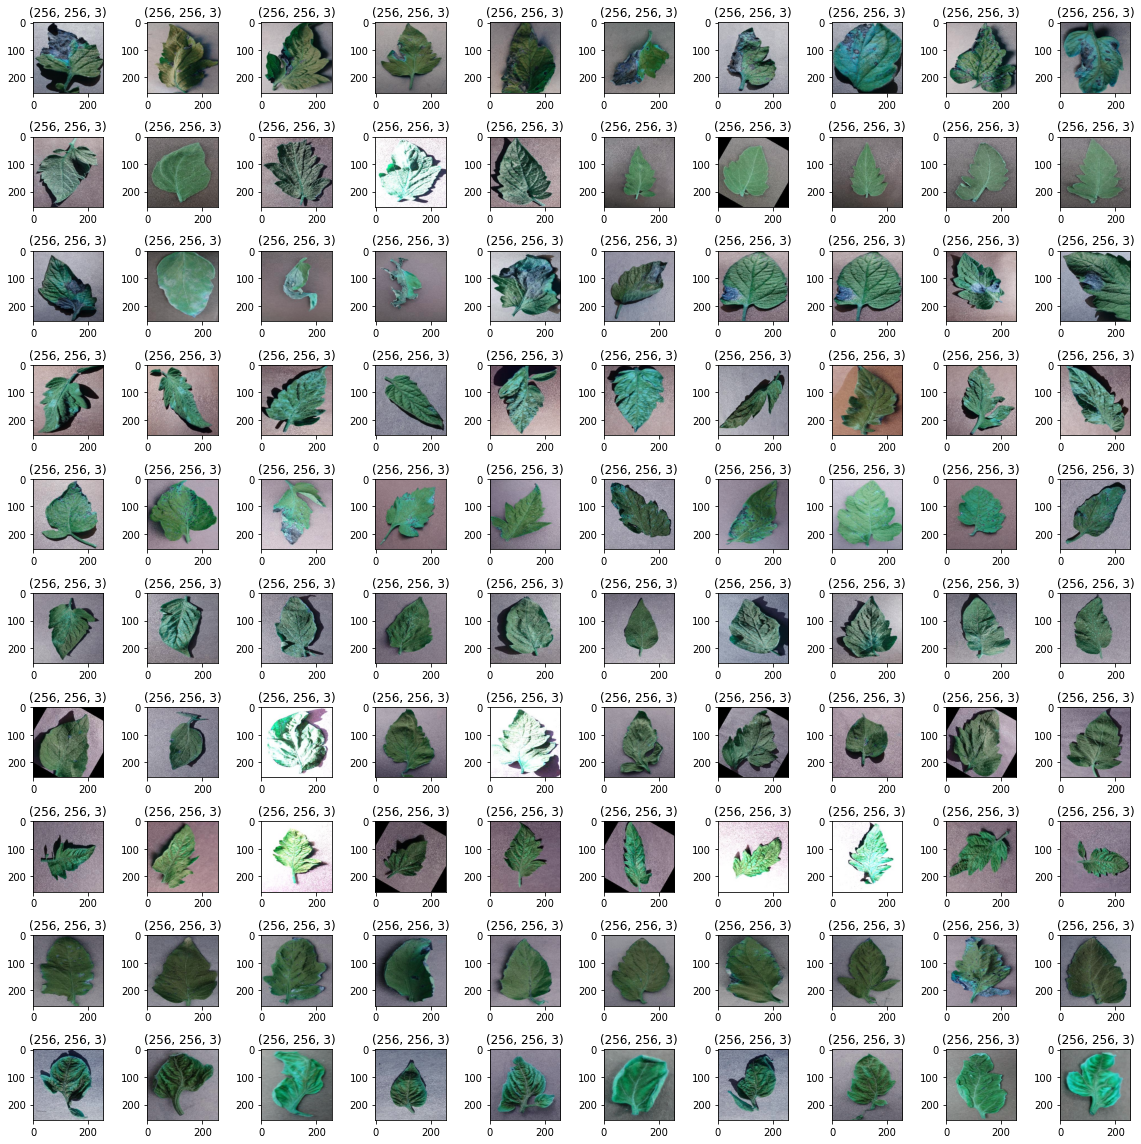

In [11]:
rows = len(os.listdir('/content/drive/MyDrive/tomato/train/'))
columns = 10

fig = plt.figure(figsize=(16, 16))
index = 0

for i in os.listdir('/content/drive/MyDrive/tomato/train/'):    
    for j in range(1, 11):
        index += 1
        img_path = random.choice([
            x for x in os.listdir('/content/drive/MyDrive/tomato/train/' + i)
            if os.path.isfile(os.path.join('/content/drive/MyDrive/tomato/train/{}'.format(i), x))
        ])
        img = cv2.imread(os.path.join('/content/drive/MyDrive/tomato/train/{}'.format(i), img_path))
        ax = fig.add_subplot(rows, columns, index, title=format(img.shape))
        plt.imshow(img)

fig.tight_layout()
plt.show()

#### Observations:
1. It can be observed that the images are of different size
2. The images are colored images hence 3 channels present.
3. Hence while importing, we are going to resize the images so all images will be of same dimensions.
4. Also, the background is similar in the images and can be easily distinguished from the plant so we will extract the plant from the background.

###Fundamental image processing


In [1]:
def extract_plant(img):
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    return clear

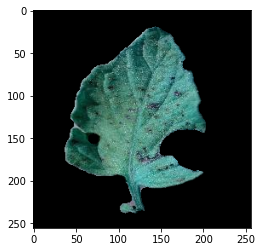

In [12]:
image = cv2.imread('/content/drive/MyDrive/tomato/train/Tomato___Early_blight/00e7c4b2-3005-4558-9cfa-235e356cb7a8___RS_Erly.B 7844.JPG')
clear_img = extract_plant(image)
plt.imshow(clear_img)

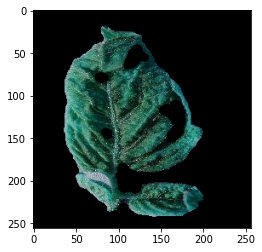

In [13]:
image = cv2.imread('/content/drive/MyDrive/tomato/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/031014d0-92fb-40a7-87d0-f000697551ef___YLCV_NREC 2679.JPG')
clear_img = extract_plant(image)
plt.imshow(clear_img)

#### Observations:
As it can observed, the plant has been masked out properly from the background.

In [14]:
X = list()
y = list()

for i in os.listdir('/content/drive/MyDrive/tomato/train/'):
    for j in os.listdir('/content/drive/MyDrive/tomato/train/' + i):
        img = cv2.imread('/content/drive/MyDrive/tomato/train/{}/{}'.format(i, j))
        img = extract_plant(img)
        img = cv2.resize(img, (128, 128))
        X.append(img)
        y.append(i)

In [15]:
X = np.asarray(X)
y = np.asarray(y)

In [16]:
print('The shape of input dataset {}'.format(X.shape))

The shape of input dataset (18345, 128, 128, 3)


In [17]:
np.array(np.unique(y, return_counts=True)).T

array([['Tomato___Bacterial_spot', '1702'],
       ['Tomato___Early_blight', '1920'],
       ['Tomato___Late_blight', '1851'],
       ['Tomato___Leaf_Mold', '1882'],
       ['Tomato___Septoria_leaf_spot', '1745'],
       ['Tomato___Spider_mites Two-spotted_spider_mite', '1741'],
       ['Tomato___Target_Spot', '1827'],
       ['Tomato___Tomato_Yellow_Leaf_Curl_Virus', '1961'],
       ['Tomato___Tomato_mosaic_virus', '1790'],
       ['Tomato___healthy', '1926']], dtype='<U45')

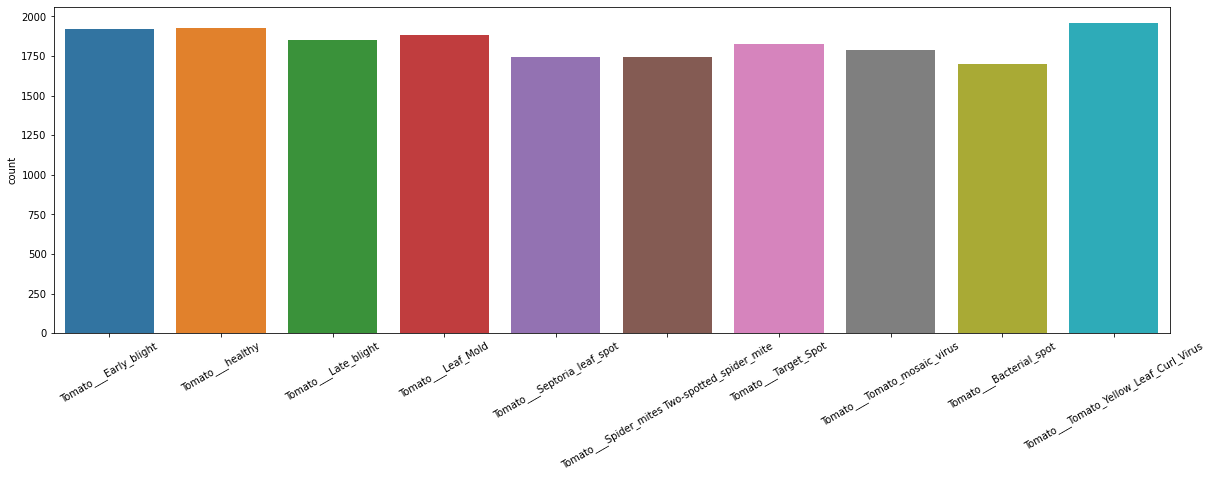

In [18]:
plt.figure(figsize=(20, 6))
sns.countplot(y)
plt.xticks(rotation=30)
plt.show()

#### Observations:
1. There are total of 18345 images available on training. 
2. It can be clearly seen that there is class imbalanced problem with the provided dataset.
3. Currently we are not generating more images to treat class imbalanced problem, we will moving forward with the data provided.

####Shuffling the data and labels

In [19]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=1)

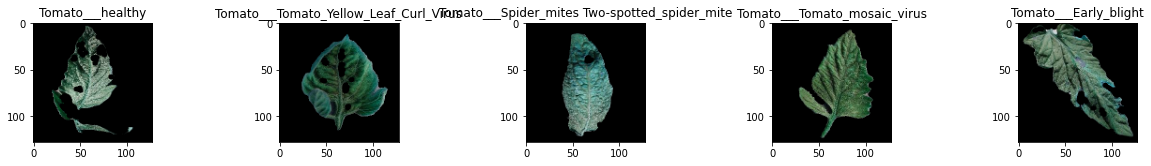

In [21]:
fig = plt.figure(figsize=(16, 16))
columns = 5
rows = 1
for i in range(1, columns*rows+1):
    img = X[i]
    ax = fig.add_subplot(rows, columns, i, title=str(y[i]))
    plt.imshow(img)

fig.tight_layout()
plt.show()

#### Observations:
1. We have shuffled the data and its label randomly.
2. It can verified in visualization, the respective label and corresponding image has been mapped properly.

In [22]:
#### Converting labels into numeric

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y = encoder.fit_transform(y)

### Splitting the data into training and testing

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Shape of training dataset: {}'.format(X_train.shape))
print('Shape of testing dataset: {}'.format(X_test.shape))

Shape of training dataset: (13758, 128, 128, 3)
Shape of testing dataset: (4587, 128, 128, 3)


### Normalizing the data

In [24]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

## Classifier model using supervised learning

As the dataset is in 4 dimension, in order to train supervised learning algorithsm, the dataset needs to be converted into 2 dimension. The steps we will doing:
1. Convert the images into grayscale
2. Flatten the grayscaled numpy array
3. Applying PCA to reduce the dimensions
4. Fit the dataset into multiple supervised algorithms and find out the best score trained model
5. Tune the hyperparameters of the best model to get best accuracy.

### Converting image into grayscale and flattening

In [25]:
def convert_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.flatten()
    return img_gray

In [26]:
X_train_converted = np.array([convert_image(x) for x in X_train])
X_test_converted = np.array([convert_image(x) for x in X_test])

In [27]:
print('The shape of converted X_train:', X_train_converted.shape)
print('The shape of converted X_test:', X_test_converted.shape)

The shape of converted X_train: (13758, 16384)
The shape of converted X_test: (4587, 16384)


### Applying Principal Component Analysis (PCA) to reduce dimensions

Here, n_components=0.90 means it will return the Eigenvectors that have the 90% of the variation in the dataset.

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)

X_train_pca = pca.fit_transform(X_train_converted)
X_test_pca = pca.transform(X_test_converted)

### Identifying the best model

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

In [30]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=11)))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('XGB', XGBClassifier(eval_metric='logloss')))

In [ ]:
results = list()
names = list()

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_pca, y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s : %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR : 0.370983 (0.009126)
KNN : 0.422372 (0.013691)
DT : 0.298590 (0.010575)
RF : 0.415177 (0.016227)
SVC : 0.570795 (0.015138)


In [ ]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Observations:
Based on the above plot, we can verify SVC is performing better with comparison among the other algorithms. So we will choose SVC for model and do hyper parameter tuning to further improve the accuracy.

### Hyper parameter tuning

In [ ]:
estimator = SVC()
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0], 
    'gamma': ['scale', 1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

kfold = KFold(n_splits=10)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=kfold)

grid_result = grid.fit(X_train_pca, y_train)

In [ ]:
print('The best params: %s' % grid_result.best_params_)
print('The best score: %s' % grid_result.best_score_)

#### Observations:
1. We have tuned the parameter of SVC model and printed out the best params.
2. The score has been slightly improved after hyperparameter tuning.

## Classifier model using Neural Networks

The steps we will doing:
1. Preprocess the input and output for fitting into neural networks
2. Finalize the architecture of the network
3. Tuning the hyper parameters to get best accuracy

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Processing training and testing data

In [ ]:
X_train_gray = np.array([cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X_train])
X_test_gray = np.array([cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X_test])

In [ ]:
print('The shape of gray scaled X_train:', X_train_gray.shape)
print('The shape of gray scaled X_test:', X_test_gray.shape)

In [ ]:
y_train_nn = to_categorical(y_train, num_classes=12)
y_test_nn = to_categorical(y_test, num_classes=12)

In [ ]:
X_train_gray = X_train_gray.reshape(648, 16384)  #change according to shape
X_test_gray = X_test_gray.reshape(217, 16384)

In [ ]:
def create_nn_model(layers, optimizer, loss, metrics, epochs, batch_size):
    model = Sequential()
    
    for layer in layers:
        model.add(layer)  
    
    print(model.summary())

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=2)
    ]

    history = model.fit(X_train_gray, y_train_nn, validation_data=(X_test_gray, y_test_nn), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

    print('_' * 100)
    print('\n')
    print('Plots of training and validation loss and accuracy \n')

    fig = plt.figure(figsize=(16, 6))
    fig.add_subplot(1, 2, 1, title='Training and Validation loss')
    plt.plot(history.epoch, history.history['loss'])
    plt.plot(history.epoch, history.history['val_loss'])
    plt.legend(['loss', 'val_loss'])

    fig.add_subplot(1, 2, 2, title='Training and Validation Accuracy')
    plt.plot(history.epoch, history.history['accuracy'])
    plt.plot(history.epoch, history.history['val_accuracy'])
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()
    plt.close()
    
    print('_' * 100)
    
    print('\n')
    print('Best Accuracy')
    print('accuracy:', np.max(history.history['accuracy']))
    print('\n')
    print('Evaluating the score on the testing data')
    print('Score:', model.evaluate(X_test_gray, y_test_nn))

    return history, model

In [ ]:
import torch
import torchvision.transforms

In [1]:
transform = transforms.Compose(
    [transforms.Resize(size = 128),
     transforms.ToTensor()])

NameError: ignored

In [ ]:
dataset = ImageFolder('/content/drive/MyDrive/tomato/train',transform=transform)
test_ds = ImageFolder('/content/drive/MyDrive/tomato/valid',transform=transform)

In [ ]:
print("Number of training images: ",len(dataset))
print("Number of testing images: ",len(test_ds))

Number of training images:  18345
Number of testing images:  4585


## Number of classes

In [ ]:
num_classes = dataset.classes
print("Number of classes: ",len(num_classes))
print(num_classes)

Number of classes:  10
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


## Visualising a single image

In [ ]:
img, label  = dataset[0]
print("Image shape:",img.shape)
print("Image Label: ",label)
print("Image Label: ",dataset.classes[label])
print(img)

Image shape: torch.Size([3, 128, 128])
Image Label:  0
Image Label:  Tomato___Bacterial_spot
tensor([[[0.5922, 0.6039, 0.6078,  ..., 0.6157, 0.6196, 0.6196],
         [0.6039, 0.6000, 0.6000,  ..., 0.6039, 0.6118, 0.6118],
         [0.6000, 0.5843, 0.5843,  ..., 0.6118, 0.6078, 0.5961],
         ...,
         [0.4627, 0.4588, 0.4627,  ..., 0.4588, 0.4588, 0.4353],
         [0.4627, 0.4588, 0.4549,  ..., 0.4549, 0.4627, 0.4510],
         [0.4667, 0.4667, 0.4549,  ..., 0.4627, 0.4706, 0.4667]],

        [[0.5686, 0.5804, 0.5843,  ..., 0.5922, 0.5961, 0.5961],
         [0.5804, 0.5765, 0.5765,  ..., 0.5804, 0.5882, 0.5882],
         [0.5765, 0.5608, 0.5608,  ..., 0.5882, 0.5843, 0.5725],
         ...,
         [0.4235, 0.4196, 0.4235,  ..., 0.4353, 0.4353, 0.4118],
         [0.4235, 0.4196, 0.4157,  ..., 0.4314, 0.4392, 0.4275],
         [0.4275, 0.4275, 0.4157,  ..., 0.4392, 0.4471, 0.4431]],

        [[0.5686, 0.5804, 0.5843,  ..., 0.6000, 0.6039, 0.6039],
         [0.5804, 0.5765, 0.57

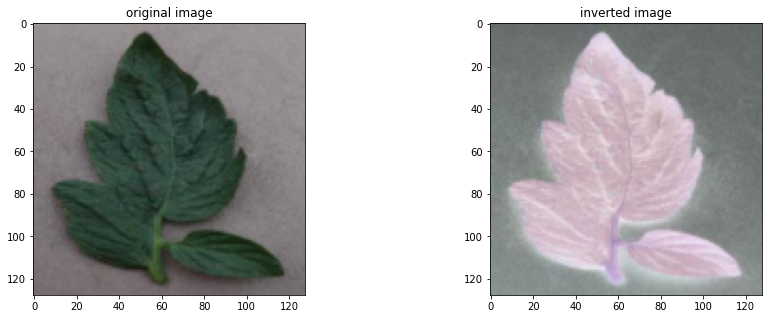

In [ ]:
img, label  = dataset[0]
fig,(ax1,ax2) = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
ax1.imshow(img.permute(1,2,0))
ax1.set_title("original image")
ax2.imshow(1-img.permute(1,2,0))
ax2.set_title("inverted image")
plt.show()

## Validation Dataset and Dataloader

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
validation_split = 0.3
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [ ]:
batch_size = 64

train_loader = DataLoader(train_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)

## Visualising a Batch of images

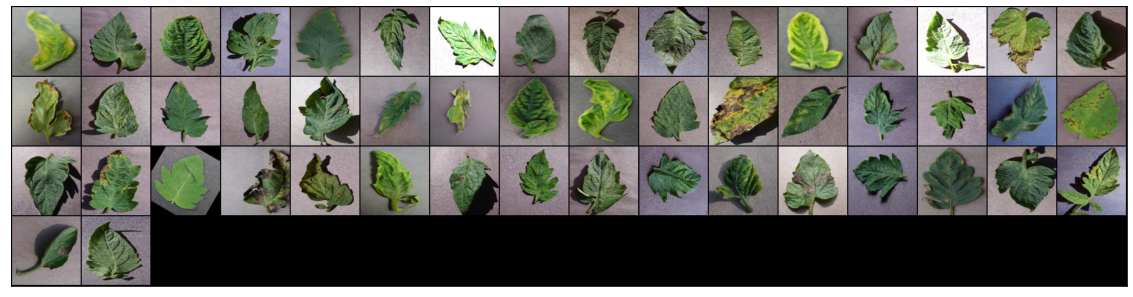

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

## Building The Model

### Building a Base Image Classification Model

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    
  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_loss = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Buiding a  CNN model 

In [ ]:
class Plant_Disease_Model(ImageClassificationBase):
  
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 64*64*64

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 128*32*32

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 256*16*16
        
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 512*8*8
        
        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 1024*4*4
        nn.AdaptiveAvgPool2d(1),
        
        nn.Flatten(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,38)
        )
    
  def forward(self,xb):
    out = self.network(xb)
    return out

### Building a VGG16 model using Transfer Learning

In [ ]:
class Plant_Disease_Model1(ImageClassificationBase):
  
  def __init__(self):
    super().__init__()
    self.network = models.vgg16(pretrained=True)
    num_ftrs = self.network.classifier[-1].in_features
    self.network.classifier[-1] = nn.Linear(num_ftrs, 38)
    
  def forward(self,xb):
    out = self.network(xb)
    return out

### Building a resnet34 model using Transfer Learning

In [ ]:
class Plant_Disease_Model2(ImageClassificationBase):
  
  def __init__(self):
    super().__init__()
    self.network = models.resnet34(pretrained=True)
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 38)
    
  def forward(self,xb):
    out = self.network(xb)
    return out

## Training and Evaluation

In [ ]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

## Using GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
model = to_device(Plant_Disease_Model2(), device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model

Plant_Disease_Model2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

## Training the model

In [ ]:
evaluate(model,val_loader)

{'val_acc': 0.025945942848920822, 'val_loss': 3.7416889667510986}

In [ ]:
history = fit(10, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.4717, val_loss: 0.2751, val_acc: 0.9059


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.1768, val_loss: 0.2119, val_acc: 0.9312


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1373, val_loss: 0.2279, val_acc: 0.9268


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0871, val_loss: 0.3054, val_acc: 0.9032


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0763, val_loss: 0.1924, val_acc: 0.9433


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0700, val_loss: 0.1691, val_acc: 0.9449


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0509, val_loss: 1.1374, val_acc: 0.8134


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0551, val_loss: 0.3811, val_acc: 0.8868


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0489, val_loss: 2.1877, val_acc: 0.7137


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0595, val_loss: 0.6738, val_acc: 0.8263


In [ ]:
history += fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0779, val_loss: 0.0993, val_acc: 0.9668


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0459, val_loss: 0.3175, val_acc: 0.9195


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0506, val_loss: 1.1593, val_acc: 0.7732


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0377, val_loss: 0.2917, val_acc: 0.9217


  0%|          | 0/257 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0265, val_loss: 0.1059, val_acc: 0.9695


## Plotting accuracy and losses

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

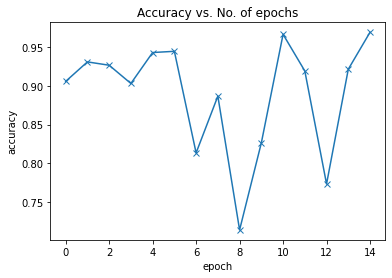

In [ ]:
plot_accuracies(history)

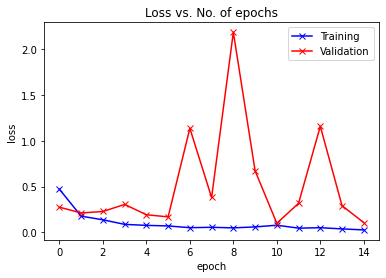

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model,val_loader)

{'val_acc': 0.9695495963096619, 'val_loss': 0.10592219978570938}

## Evaluation and Prediction on Test Data

In [ ]:
x = evaluate(model,test_loader)
x

{'val_acc': 0.9694720506668091, 'val_loss': 0.10513513535261154}

#### **Accuracy of the model on test data : 98.420%**

## Prediction on some single image of test data

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: Tomato___Bacterial_spot , Predicted: Tomato___Bacterial_spot


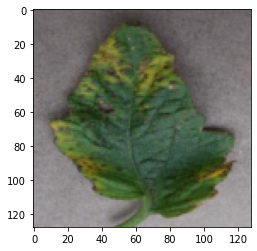

In [ ]:
img, label = test_ds[25]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Tomato___Late_blight , Predicted: Tomato___Late_blight


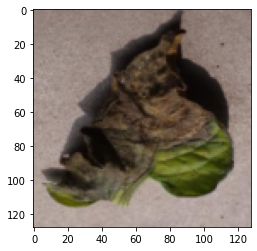

In [ ]:
img, label = test_ds[978]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Tomato___Spider_mites Two-spotted_spider_mite , Predicted: Tomato___Spider_mites Two-spotted_spider_mite


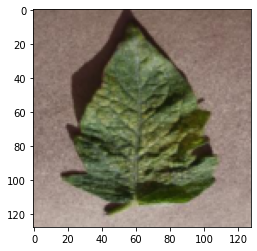

In [ ]:
img, label = test_ds[2548]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Tomato___Leaf_Mold , Predicted: Tomato___Leaf_Mold


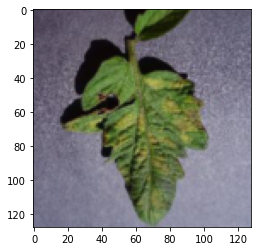

In [ ]:
img, label = test_ds[1548]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Tomato___Late_blight , Predicted: Tomato___Late_blight


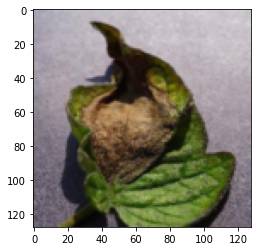

In [ ]:
img, label = test_ds[1248]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

## Saving the Model

In [ ]:
torch.save(model.state_dict(), 'plantDisease-resnet34.pth')